In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import numpy as np
import plotly.express as ex
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from math import sqrt

from tracking.kalman import kalman_pv
from tracking.util import to_df, colorscale

# Kalman gain with varying sampling interval

We have already analyzed how Kalman Gain converges to a specific value when tracking a single target with constant measurement noise and constant sampling rate? What will the convergence of Kalman Gain look like when the sampling interval is not constant?

In [56]:
def simulate_kalman_1d(Q_intensity, R, time):
    P = R

    trace = []
    for time, dt in zip(time[1:], np.diff(np.array(time))):
        Q = dt**3/3 * Q_intensity
        P = P + Q
        K = P/(P+R)
        P = (1-K)*P
        trace.append((time, dt, K, P))
    return to_df(np.array(trace), columns=['t', 'dt', 'K', 'P'])

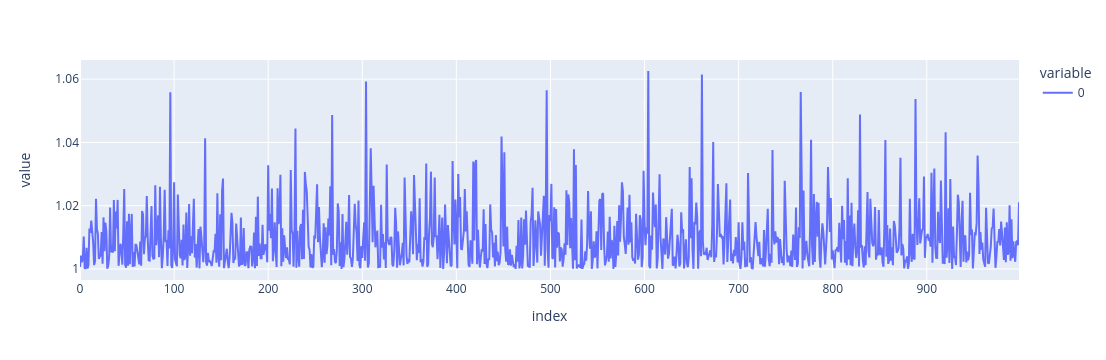

In [66]:
time = np.cumsum(1+np.random.exponential(.01, size=1000))
ex.line(np.diff(time))

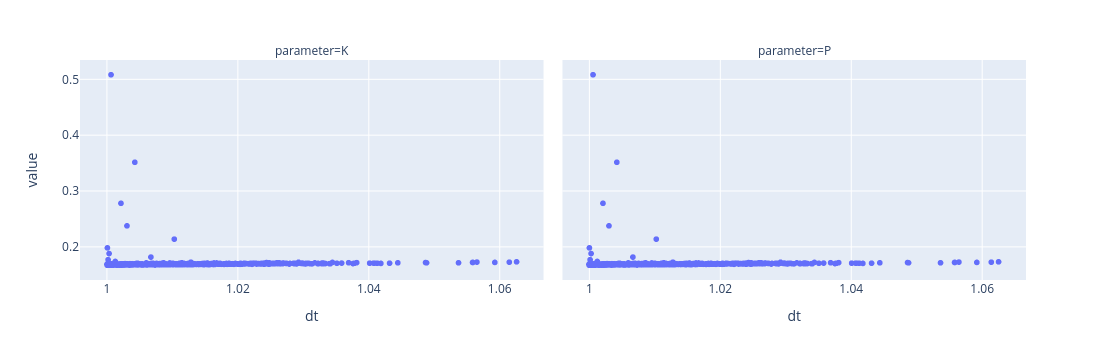

In [67]:
trace = simulate_kalman_1d(.1, 1, time).melt(id_vars=['dt', 't'], var_name='parameter')
ex.scatter(trace, x='dt', y='value', facet_col='parameter')

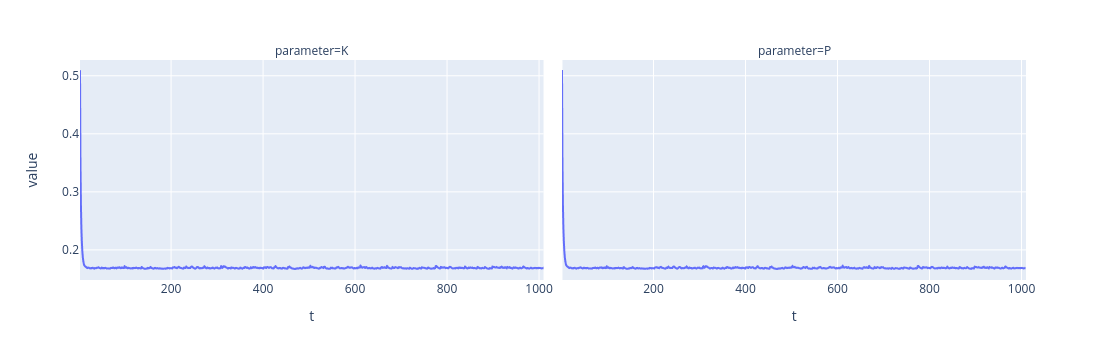

In [69]:
ex.line(trace, x='t', y='value', facet_col='parameter')

In [30]:
def simulate_kalman_2d(Q_intensity, R, time):
    H = np.array([[1, 0]])
    P = np.array([[R, 0], [0, R]])
    R = np.eye(1) * R

    trace = []
    for dt in np.diff(np.array(time)):
        # "Estimation with Applications to Tracking and Navigation", p. 270
        # process noise for the continuous white noise acceleration (CWNA)
        # model; velocity changes at discrete time intervals by white-noise
        # derived values
        dt3 = dt**3 / 3
        dt2 = dt**2 / 2
        Q = np.array([[dt3, dt2], [dt2, dt]]) * Q_intensity

        # state transition matrix
        F = np.array([[1, dt], [0, 1]])

        # Kalman update as it pertains only to covariance and Kalman gain
        # (state is not a value of interest)
        P = F @ P @ F.T + Q
        S = H @ P @ H.T + R
        K = P @ H.T @ np.linalg.inv(S)
    
        P = P - K @ S @ K.T

        trace.append((P, K))
    
    return tuple([np.array(x) for x in zip(*trace)])

In [31]:
time = np.cumsum(np.abs(np.random.normal(1, .1, size=100)))
simulate_kalman_2d(1, 1, time)

(array([[[0.66273538, 0.41817972],
         [0.41817972, 1.34692302]],
 
        [[0.78115162, 0.53884541],
         [0.53884541, 1.10270967]],
 
        [[0.78899018, 0.49677678],
         [0.49677678, 1.03200174]],
 
        [[0.74776113, 0.4882967 ],
         [0.4882967 , 1.04047352]],
 
        [[0.78711832, 0.49382028],
         [0.49382028, 1.03287732]],
 
        [[0.7186733 , 0.48402386],
         [0.48402386, 1.04345545]],
 
        [[0.75605574, 0.49898138],
         [0.49898138, 1.03158913]],
 
        [[0.72956611, 0.49053771],
         [0.49053771, 1.03219502]],
 
        [[0.75846801, 0.49629693],
         [0.49629693, 1.02812302]],
 
        [[0.74622808, 0.49163693],
         [0.49163693, 1.03225427]],
 
        [[0.78252951, 0.49346691],
         [0.49346691, 1.02980266]],
 
        [[0.73325612, 0.48702637],
         [0.48702637, 1.04085516]],
 
        [[0.75827456, 0.49690897],
         [0.49690897, 1.03294521]],
 
        [[0.76360713, 0.49299512],
         [0.4929